# DELE ST1504 CA2
# PART A: GAN

<hr>

**NAME**: Irman Zafyree, Adam Tan, Joachim

**ADMIN NO**: `2300546`, `2300575`, `<ADM NO>`

**CLASS**: DAAA/FT/2B/07

<hr>

**Objective:**

Code a GAN model that is able to generate 260 small black-and-white images of the given dataset in 26 distinct classes.

**Background:**
A Generative Adversarial Network (GAN) is a type of deep learning model consisting of two neural networks: a generator and a discriminator. The primary purpose of a GAN is to generate new data instances that resemble the training data, through a competitive process between a generator and a discriminator. It has revolutionized the field of generative modeling and continues to be a vibrant area of research and application in artificial intelligence.





# Initial Set Up

In [25]:
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

load_dotenv()

dataset_path = os.environ.get("DATASET_PATH")

print(dataset_path)




emnist-letters-train.csv


In [26]:
df = pd.read_csv(dataset_path, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Background Research

**CSV Dataset:**
- the datatset consists of 99040 datasets
- the first column represents the classs labels -1 to 26.
- Remaining 784 columns are the pixel data

**Classes:**

Total of 27 distinct classes 
1. -1 (all black)
2. 1 (a)
3. 2 (b)
4. 3 (c)
5. 4 (d)
6. 5 (e)
7. 6 (f)
8. 7 (g)
9. 8 (h)
10. 9 (i)
11. 10 (j)
12. 11 (k)
13. 12 (l)
14. 13 (m)
15. 14 (n)
16. 15 (o)
17. 16 (p)
18. 17 (q)
19. 18 (r)
20. 19 (s)
21. 20 (t)
22. 21 (u)
23. 22 (v)
24. 23 (w)
25. 24 (x)
26. 25 (y)
27. 26 (z)


**Images:**

The images are of size 28x28

In [27]:
labels = df[0]

In [28]:
data = df.drop(df.columns[0], axis=1)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


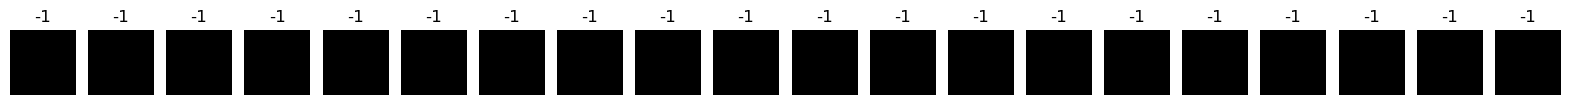

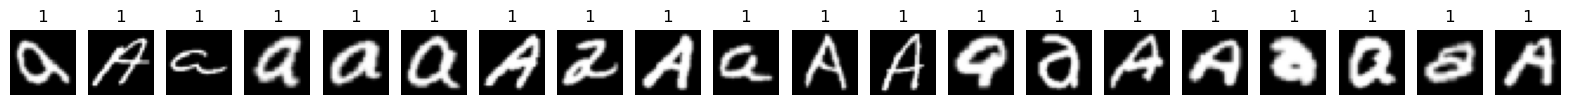

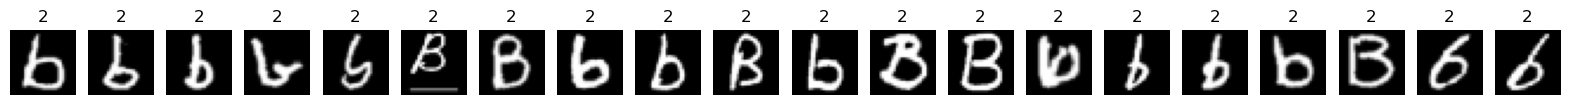

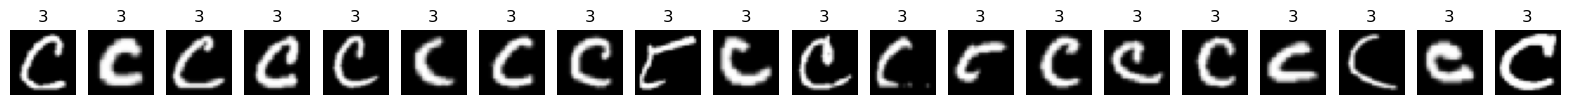

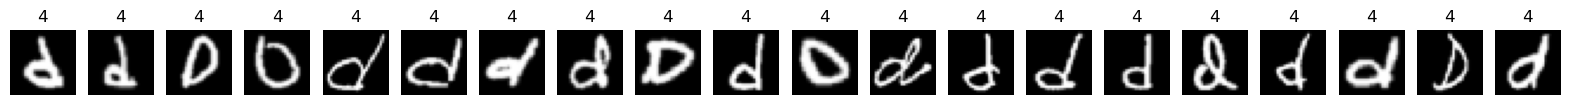

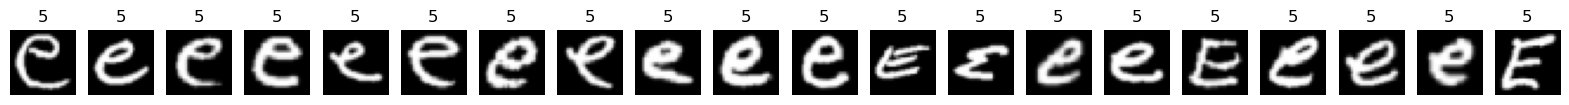

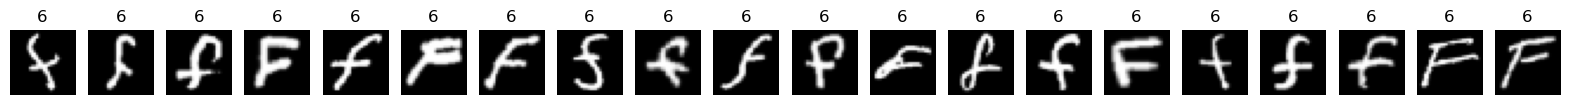

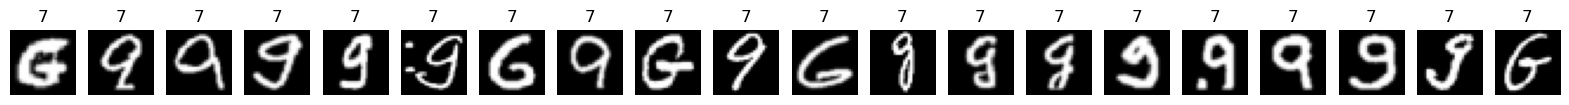

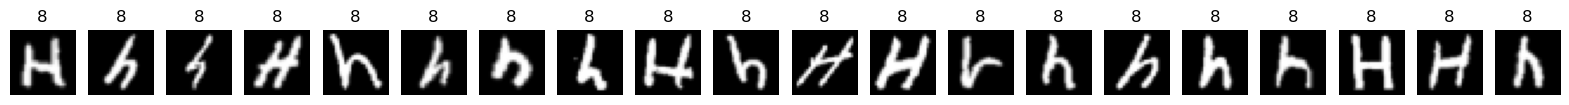

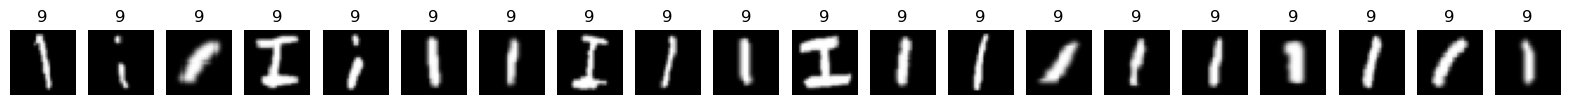

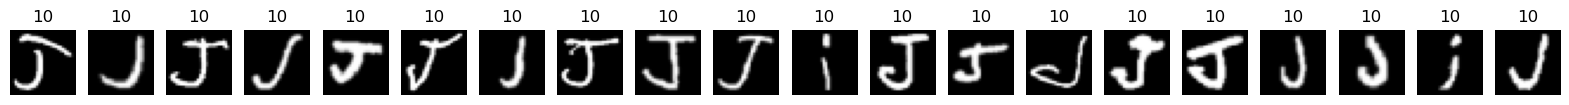

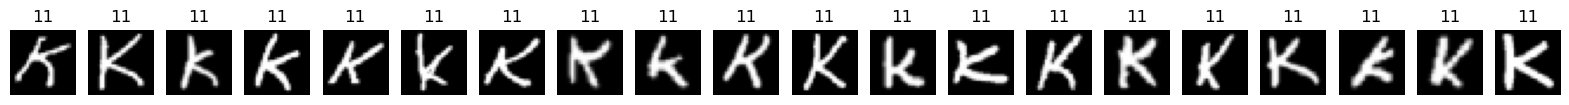

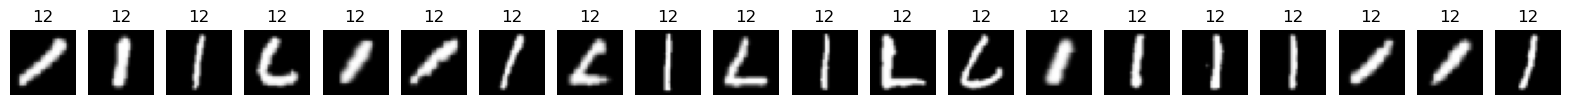

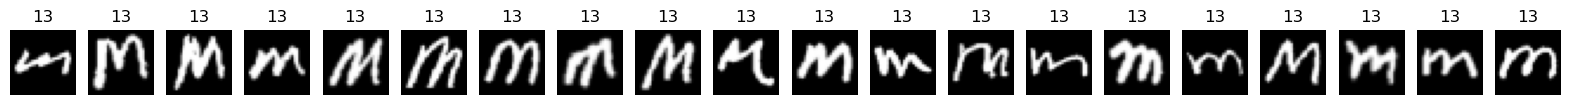

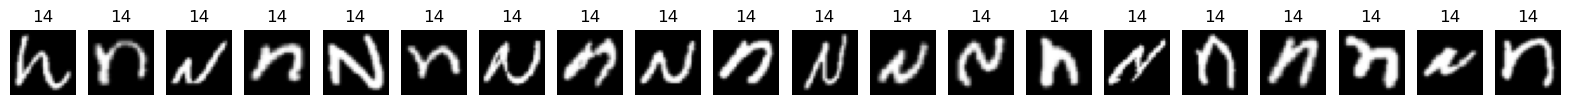

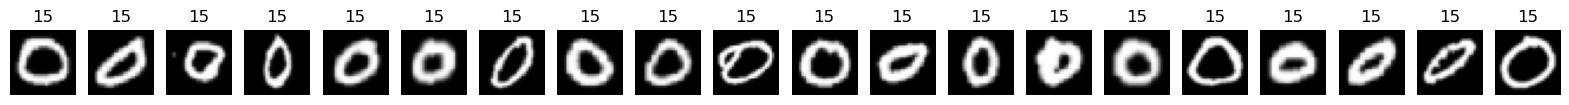

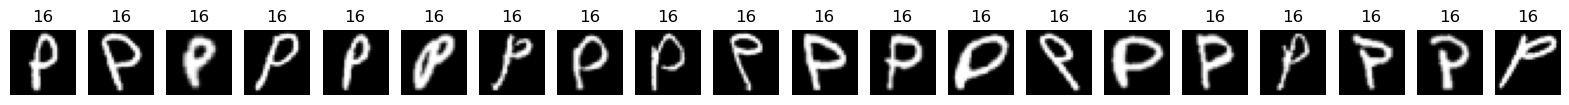

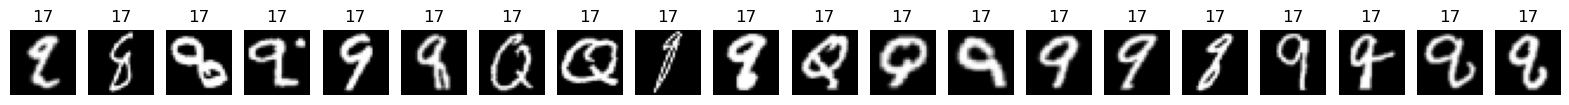

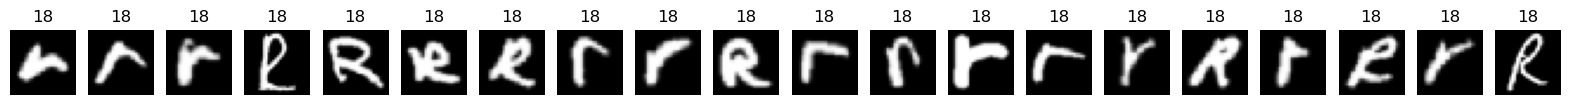

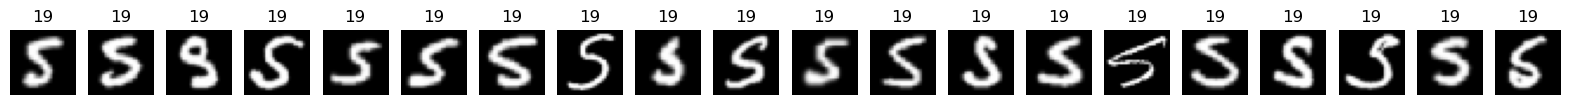

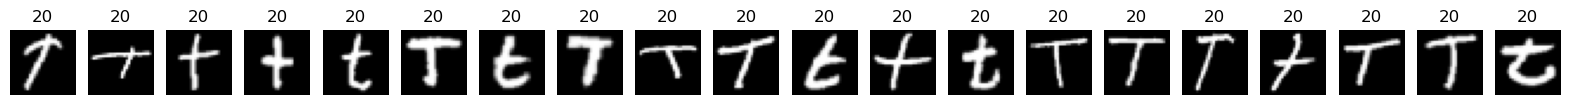

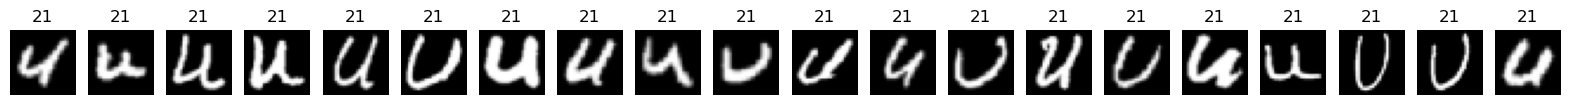

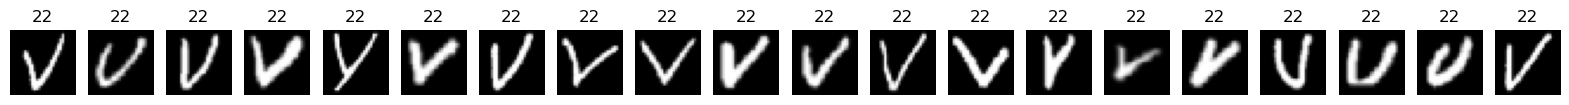

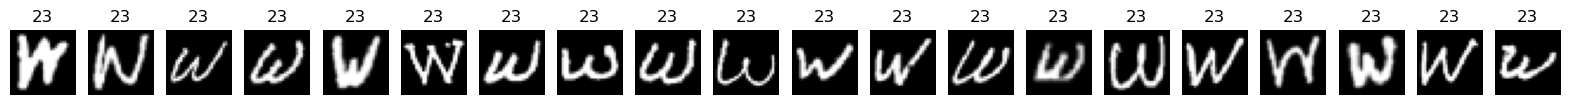

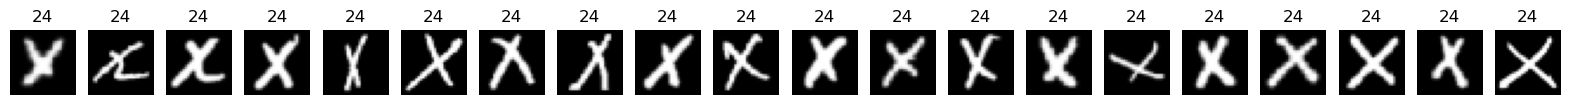

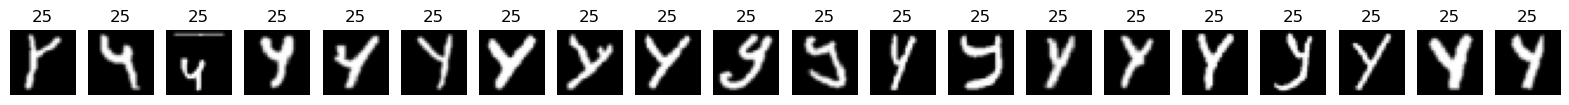

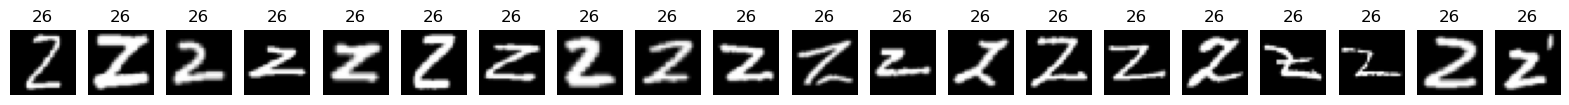

In [29]:

# Function to display images
def display_images(images, label):
    plt.figure(figsize=(20, 4))
    for index, image in enumerate(images[:20]):
        plt.subplot(1, 20, index + 1)
        image = np.array(image).reshape(28, 28)
        rotated_image = np.rot90(image, k=-1)  
        flipped_horizontal = np.fliplr(rotated_image)
        plt.imshow(flipped_horizontal, cmap='gray')
        plt.axis('off')
        plt.title(f"{label}")

# Order labels from -1 to 26
ordered_labels = sorted(labels.unique(), key=lambda x: (x != -1, x))

# Iterate through each ordered label and display 10 images
for label in ordered_labels:
    label_images = data[labels == label].values
    display_images(label_images, label)
    plt.show()

Class distribution:
Label -1: 10240 instances
Label 1: 3396 instances
Label 2: 3396 instances
Label 3: 3419 instances
Label 4: 3398 instances
Label 5: 3437 instances
Label 6: 3394 instances
Label 7: 3385 instances
Label 8: 3424 instances
Label 9: 3428 instances
Label 10: 3402 instances
Label 11: 3438 instances
Label 12: 3415 instances
Label 13: 3402 instances
Label 14: 3365 instances
Label 15: 3408 instances
Label 16: 3430 instances
Label 17: 3435 instances
Label 18: 3419 instances
Label 19: 3392 instances
Label 20: 3436 instances
Label 21: 3419 instances
Label 22: 3422 instances
Label 23: 3423 instances
Label 24: 3437 instances
Label 25: 3453 instances
Label 26: 3427 instances


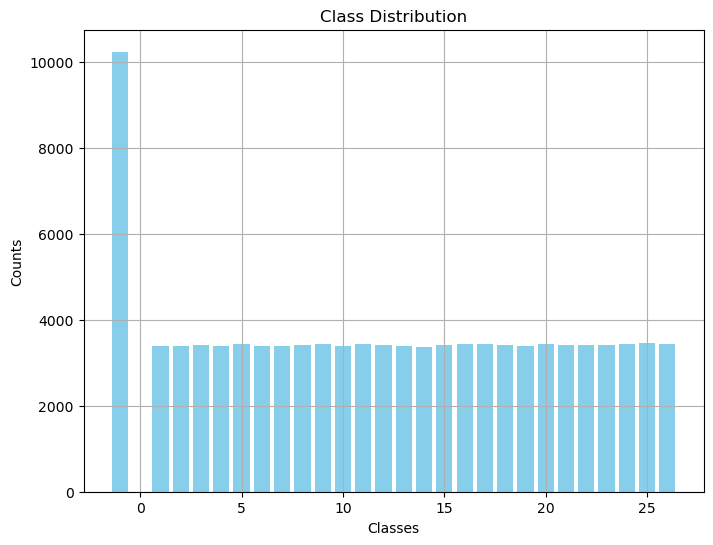

In [30]:
import numpy as np

# Count occurrences of each label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Print the distribution
print("Class distribution:")
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} instances")

plt.figure(figsize=(8, 6))  # Specify the figure size (optional)
plt.bar(unique_labels, label_counts, color='skyblue')

# Customize the chart
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.grid(True)  # Add gridlines for better readability (optional)

# Display the chart
plt.show()

In [ ]:
def average_images_per_class(train_data, unique_labels):
    # Dictionary to keep the sum of all images for each class and a count of images
    class_sums = {name: (tf.zeros_like(
        next(iter(train_data))[0]), 0) for name in unique_labels}

    # Iterate over the dataset and sum up the images tensor-wise for each class
    for image, label in train_data:
        class_name = unique_labels[label.numpy()]
        sum_images, count = class_sums[class_name]
        class_sums[class_name] = (sum_images + image, count + 1)

    class_averages = {name: (image_sum / count)
                    for name, (image_sum, count) in class_sums.items()}

    # Create a grid for subplots
    fig, axes = plt.subplots(3, 5, figsize=(20, 15))
    for ax, (class_name, avg_image) in zip(axes.flatten(), class_averages.items()):
        ax.imshow(avg_image, cmap = "gray")
        ax.set_title(f"Average image for {class_name}")
        ax.axis('off')  # Turn off axis

    plt.suptitle("Average of each class in the dataset")
    plt.tight_layout()
    plt.show()
